In [84]:
from collections import Counter

# Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.core.dtypes.common import validate_all_hashable

# ML Algorithms
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# 1.0 Import the data

In [97]:
df = pd.read_csv('NBA_Dataset.csv')

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17697 entries, 0 to 17696
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            17697 non-null  int64  
 1   player            17697 non-null  object 
 2   pos               17697 non-null  object 
 3   age               17697 non-null  int64  
 4   team_id           17697 non-null  object 
 5   g                 17697 non-null  int64  
 6   gs                17697 non-null  int64  
 7   mp_per_g          17697 non-null  float64
 8   fg_per_g          17697 non-null  float64
 9   fga_per_g         17697 non-null  float64
 10  fg_pct            17634 non-null  float64
 11  fg3_per_g         17697 non-null  float64
 12  fg3a_per_g        17697 non-null  float64
 13  fg3_pct           15074 non-null  float64
 14  fg2_per_g         17697 non-null  float64
 15  fg2a_per_g        17697 non-null  float64
 16  fg2_pct           17591 non-null  float6

# 2.0 EDA / Feature Engineering

In [99]:
#Check if there is any null values
df.isnull().sum()

season                 0
player                 0
pos                    0
age                    0
team_id                0
g                      0
gs                     0
mp_per_g               0
fg_per_g               0
fga_per_g              0
fg_pct                63
fg3_per_g              0
fg3a_per_g             0
fg3_pct             2623
fg2_per_g              0
fg2a_per_g             0
fg2_pct              106
efg_pct               63
ft_per_g               0
fta_per_g              0
ft_pct               576
orb_per_g              0
drb_per_g              0
trb_per_g              0
ast_per_g              0
stl_per_g              0
blk_per_g              0
tov_per_g              0
pf_per_g               0
pts_per_g              0
mp                     0
per                    3
ts_pct                55
fg3a_per_fga_pct      63
fta_per_fga_pct       63
orb_pct                3
drb_pct                3
trb_pct                3
ast_pct                3
stl_pct                3


In [100]:
df[df['fg_pct'].isnull()][['player', 'fga_per_g']].head()

,player,fga_per_g
1407,Yvon Joseph,0.0
2077,Jeff Lamp,0.0
2602,David Wood,0.0
2956,Mark Wade,0.0
3183,Gary Leonard,0.0


In [101]:
df[df['fg3_pct'].isnull()][['player', 'fg3_per_g']].head()

,player,fg3_per_g
5,Dennis Awtrey,0.0
6,Carl Bailey,0.0
7,James Bailey,0.0
12,Mel Bennett,0.0
21,Brad Branson,0.0


Most of the null values are in the percentages meaning the player did not attempt to score a type of field goal and giving a 0/0 error 

In [102]:
df = df.fillna(0)

In [49]:
# Add a column to see who won the mvp with a boolean value
mvp = df.groupby('season').max('award_share')
mvp['is_mvp'] = True

df = df.merge(mvp[['award_share', 'is_mvp']], on = ['season', 'award_share'], how = 'left')
df['is_mvp'] = df['is_mvp'].fillna(value = False)

In [50]:
df

,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,is_mvp
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,...,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,False
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,...,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,False
2,1982,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,...,0.061,2.3,-1.6,0.7,1.0,0.000,-4.43,-4.48,0.341,False
3,1982,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,...,0.042,-3.7,1.0,-2.7,-0.1,0.000,6.38,6.35,0.768,False
4,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,...,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17692,2022,Thaddeus Young,PF,33,TOT,52,1,16.3,2.7,5.2,...,0.126,0.1,2.1,2.2,0.9,0.000,0.00,0.00,0.500,False
17693,2022,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,...,0.181,7.1,-2.0,5.2,4.8,0.000,1.56,1.55,0.524,False
17694,2022,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,...,0.145,-1.4,0.4,-1.0,0.2,0.000,4.45,4.23,0.646,False
17695,2022,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,...,0.143,-1.2,-1.0,-2.1,0.0,0.000,-8.88,-8.55,0.329,False


Since fg_per_g is a derivative of fga_per_g with fg_pct, it is pretty much a repetitive stat that adds no value so I am dropping it along some some other stats

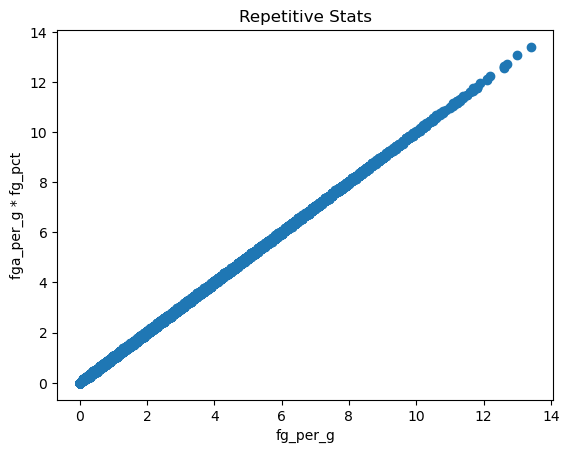

In [51]:
plt.scatter(df['fg_per_g'], df['fga_per_g'] * df['fg_pct'])
plt.xlabel('fg_per_g')
plt.ylabel('fga_per_g * fg_pct')
plt.title('Repetitive Stats')
plt.show()

In [52]:
df = df.drop(columns= ['fg_per_g', 'fg3_per_g', 'fg2_per_g', 'ft_per_g', 'trb_per_g'], axis = 1)
df

,season,player,pos,age,team_id,g,gs,mp_per_g,fga_per_g,fg_pct,...,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,is_mvp
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,17.1,0.579,...,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,False
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,13.0,0.494,...,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,False
2,1982,Mark Aguirre,SF,22,DAL,51,20,28.8,16.1,0.465,...,0.061,2.3,-1.6,0.7,1.0,0.000,-4.43,-4.48,0.341,False
3,1982,Danny Ainge,SG,22,BOS,53,1,10.6,4.2,0.357,...,0.042,-3.7,1.0,-2.7,-0.1,0.000,6.38,6.35,0.768,False
4,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,9.6,0.472,...,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17692,2022,Thaddeus Young,PF,33,TOT,52,1,16.3,5.2,0.518,...,0.126,0.1,2.1,2.2,0.9,0.000,0.00,0.00,0.500,False
17693,2022,Trae Young,PG,23,ATL,76,76,34.9,20.3,0.460,...,0.181,7.1,-2.0,5.2,4.8,0.000,1.56,1.55,0.524,False
17694,2022,Omer Yurtseven,C,23,MIA,56,12,12.6,4.4,0.526,...,0.145,-1.4,0.4,-1.0,0.2,0.000,4.45,4.23,0.646,False
17695,2022,Cody Zeller,C,29,POR,27,0,13.1,3.3,0.567,...,0.143,-1.2,-1.0,-2.1,0.0,0.000,-8.88,-8.55,0.329,False


I am separating season 2022 to see if my model have the power to predict new data

In [53]:
df_test_set = df[df['season'] == 2022]
df = df[df['season'] < 2022]
df

,season,player,pos,age,team_id,g,gs,mp_per_g,fga_per_g,fg_pct,...,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,is_mvp
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,17.1,0.579,...,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,False
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,13.0,0.494,...,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,False
2,1982,Mark Aguirre,SF,22,DAL,51,20,28.8,16.1,0.465,...,0.061,2.3,-1.6,0.7,1.0,0.000,-4.43,-4.48,0.341,False
3,1982,Danny Ainge,SG,22,BOS,53,1,10.6,4.2,0.357,...,0.042,-3.7,1.0,-2.7,-0.1,0.000,6.38,6.35,0.768,False
4,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,9.6,0.472,...,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17087,2021,Delon Wright,SG-PG,28,TOT,63,39,27.7,8.2,0.463,...,0.117,0.6,1.5,2.2,1.8,0.000,0.00,0.00,0.500,False
17088,2021,Thaddeus Young,PF,32,CHI,68,23,24.3,9.7,0.559,...,0.147,1.9,1.4,3.3,2.2,0.000,-0.89,-0.94,0.431,False
17089,2021,Trae Young,PG,22,ATL,63,63,33.7,17.7,0.438,...,0.163,5.3,-1.7,3.7,3.0,0.000,2.32,2.14,0.569,False
17090,2021,Cody Zeller,C,28,CHO,48,21,20.9,6.8,0.559,...,0.156,-0.2,-0.2,-0.5,0.4,0.000,-1.93,-1.94,0.458,False


# 3.0 Data Visualization

Since only 1 player can win regular season MVP we can safely assume that this will be a imbalanced dataset and see if we can figure out what contributes to being an MVP

In [54]:
df['is_mvp'].value_counts()

False    17052
True        40
Name: is_mvp, dtype: int64

In [55]:
mvp_shares = df[df['award_share'] > 0]
non_mvp_share = df[df['award_share'] == 0]

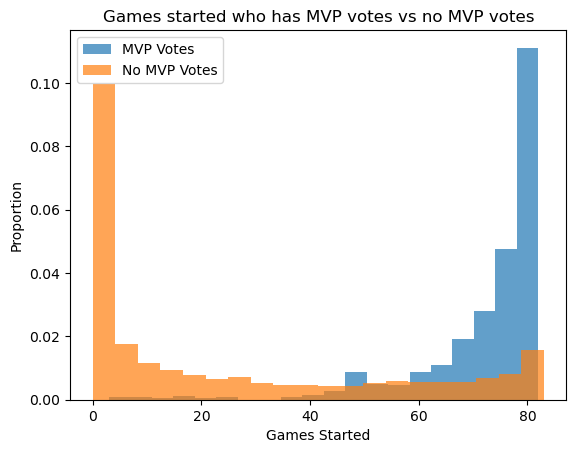

In [56]:
plt.hist(mvp_shares['gs'], bins = 20, alpha = 0.7, density = True, label = 'MVP Votes')
plt.hist(non_mvp_share['gs'], bins = 20, alpha = 0.7, density = True, label = 'No MVP Votes')
plt.ylabel('Proportion')
plt.xlabel('Games Started')
plt.title('Games started who has MVP votes vs no MVP votes')
plt.legend()
plt.show()

Looks like there are players who received mvp votes even though they only started for only less than 20 games

In [57]:
mvp_shares[mvp_shares['gs'] < 20][['season', 'player', 'g', 'gs', 'pts_per_g', 'award_share']].reset_index(drop = True)

,season,player,g,gs,pts_per_g,award_share
0,1982,Michael Cooper,76,14,11.9,0.004
1,1991,Kevin McHale,68,10,18.4,0.001
2,1992,Detlef Schrempf,80,4,17.3,0.001
3,1995,Michael Jordan,17,17,26.9,0.011
4,1996,Magic Johnson,32,9,14.6,0.007
5,1999,Darrell Armstrong,50,15,13.8,0.002
6,1999,Rasheed Wallace,49,18,12.8,0.001
7,2021,Derrick Rose,50,3,14.7,0.010


There are notable names here, but what is surprising is Derrick Rose in 2021. He played with the Detroit Pistons and New York Knicks during this season and some people still believed that he can still play at his former self in this season.

In [58]:
# Updating the dataset where we filter the players who played less than 20 games as it is highly unlikely they will win a MVP
df = df[df['gs'] > 20].reset_index(drop = True)
df.shape

# From 17000 rows we lost atleast 10000 rows on the dataset

(7132, 51)

We can further filter out the dataset because you do not win a MVP if they don't play any minutes

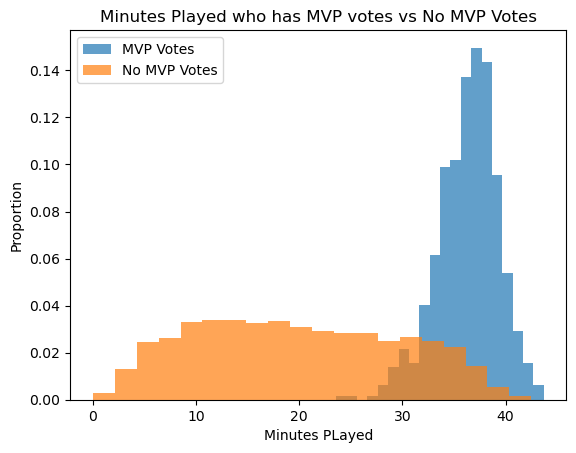

 The cutoff is 27.574 minutes per game


In [59]:
plt.hist(mvp_shares['mp_per_g'], bins = 20, alpha = 0.7, density = True, label = 'MVP Votes')
plt.hist(non_mvp_share['mp_per_g'], bins = 20, alpha = 0.7, density = True, label = 'No MVP Votes')
plt.xlabel('Minutes PLayed')
plt.ylabel('Proportion')
plt.title('Minutes Played who has MVP votes vs No MVP Votes')
plt.legend()
plt.show()

minute_cutoff = mvp_shares['mp_per_g'].mean() - 3 * mvp_shares['mp_per_g'].std()
print(f" The cutoff is {minute_cutoff:.3f} minutes per game")

In [60]:
mvp_shares[mvp_shares['mp_per_g'] < minute_cutoff]\
[['season', 'player', 'mp_per_g', 'pts_per_g', 'award_share']].reset_index(drop = True)

,season,player,mp_per_g,pts_per_g,award_share
0,1983,Alton Lister,23.6,8.4,0.007
1,1999,Arvydas Sabonis,27.0,12.1,0.003
2,2021,Derrick Rose,25.6,14.7,0.010


In [61]:
df = df[df['mp_per_g'] > minute_cutoff].reset_index(drop = True)
df

,season,player,pos,age,team_id,g,gs,mp_per_g,fga_per_g,fg_pct,...,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,is_mvp
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,17.1,0.579,...,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,False
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,13.0,0.494,...,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,False
2,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,9.6,0.472,...,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,False
3,1982,Greg Ballard,SF,27,WSB,79,79,37.3,16.5,0.475,...,0.154,1.5,1.7,3.2,3.9,0.000,0.88,1.06,0.524,False
4,1982,Kent Benson,C,27,DET,75,72,32.9,10.7,0.505,...,0.101,0.0,0.4,0.4,1.5,0.000,-0.91,-0.63,0.476,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4611,2021,Patrick Williams,PF,19,CHI,71,71,27.9,7.4,0.483,...,0.060,-2.8,0.4,-2.4,-0.2,0.000,-0.89,-0.94,0.431,False
4612,2021,Zion Williamson,PF,20,NOP,61,61,33.2,17.0,0.611,...,0.205,6.1,-0.3,5.8,4.0,0.000,-0.29,-0.20,0.431,False
4613,2021,Christian Wood,C,25,HOU,41,41,32.3,15.6,0.514,...,0.100,1.7,-0.3,1.4,1.1,0.000,-7.90,-7.50,0.236,False
4614,2021,Delon Wright,SG-PG,28,TOT,63,39,27.7,8.2,0.463,...,0.117,0.6,1.5,2.2,1.8,0.000,0.00,0.00,0.500,False


Checking the relationship of points per game for mvp candidates

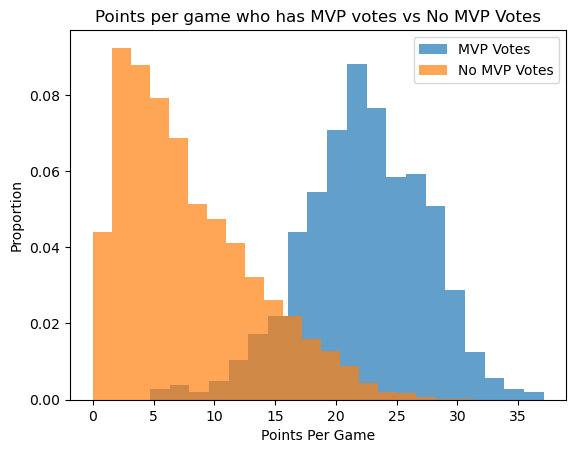

 The cutoff is 6.906 points per game


In [62]:
plt.hist(mvp_shares['pts_per_g'], bins = 20, alpha = 0.7, density = True, label = 'MVP Votes')
plt.hist(non_mvp_share['pts_per_g'], bins = 20, alpha = 0.7, density = True, label = 'No MVP Votes')
plt.xlabel('Points Per Game')
plt.ylabel('Proportion')
plt.title('Points per game who has MVP votes vs No MVP Votes')
plt.legend()
plt.show()

point_cutoff = mvp_shares['pts_per_g'].mean() - 3 * mvp_shares['pts_per_g'].std()
print(f" The cutoff is {point_cutoff:.3f} points per game")

In [63]:
mvp_shares[mvp_shares['pts_per_g'] < point_cutoff]\
[['season', 'player', 'mp_per_g', 'pts_per_g', 'award_share']].reset_index(drop = True)

,season,player,mp_per_g,pts_per_g,award_share
0,1989,Mark Eaton,35.5,6.2,0.004
1,1994,Dennis Rodman,37.8,4.7,0.001
2,1996,Dennis Rodman,32.6,5.5,0.004
3,2003,Ben Wallace,39.4,6.9,0.028


In [64]:
# Drop players who had less than 7 points per game
df = df[df['pts_per_g'] > point_cutoff].reset_index(drop = True)
df

,season,player,pos,age,team_id,g,gs,mp_per_g,fga_per_g,fg_pct,...,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,is_mvp
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,17.1,0.579,...,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,False
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,13.0,0.494,...,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,False
2,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,9.6,0.472,...,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,False
3,1982,Greg Ballard,SF,27,WSB,79,79,37.3,16.5,0.475,...,0.154,1.5,1.7,3.2,3.9,0.000,0.88,1.06,0.524,False
4,1982,Kent Benson,C,27,DET,75,72,32.9,10.7,0.505,...,0.101,0.0,0.4,0.4,1.5,0.000,-0.91,-0.63,0.476,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4562,2021,Patrick Williams,PF,19,CHI,71,71,27.9,7.4,0.483,...,0.060,-2.8,0.4,-2.4,-0.2,0.000,-0.89,-0.94,0.431,False
4563,2021,Zion Williamson,PF,20,NOP,61,61,33.2,17.0,0.611,...,0.205,6.1,-0.3,5.8,4.0,0.000,-0.29,-0.20,0.431,False
4564,2021,Christian Wood,C,25,HOU,41,41,32.3,15.6,0.514,...,0.100,1.7,-0.3,1.4,1.1,0.000,-7.90,-7.50,0.236,False
4565,2021,Delon Wright,SG-PG,28,TOT,63,39,27.7,8.2,0.463,...,0.117,0.6,1.5,2.2,1.8,0.000,0.00,0.00,0.500,False


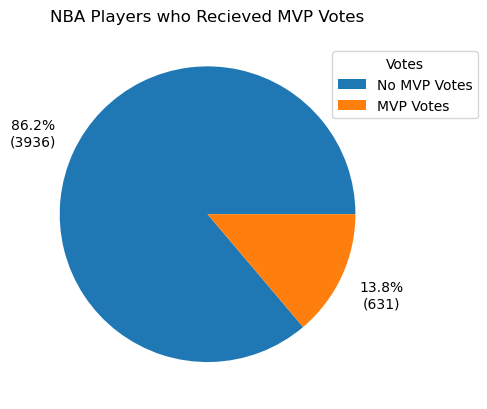

In [65]:
classes = df["award_share"] > 0

data_df = df.drop(["player", "pos", "team_id", "is_mvp"], axis = 1)
unSmoteLen = len(data_df)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(), 
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 1.3)

ax.set_title("NBA Players who Recieved MVP Votes")

ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()

# I am going use smote as even out the data

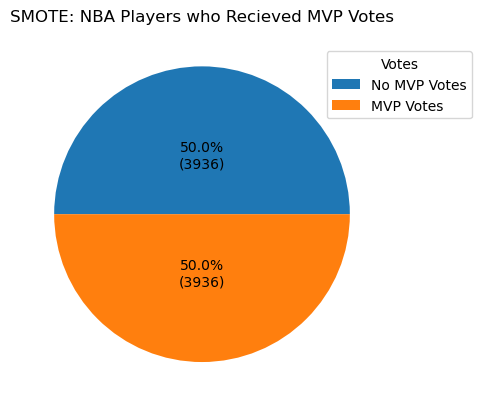

In [68]:
smote = SMOTE(sampling_strategy = 1)
data_df, classes = smote.fit_resample(data_df, classes)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(), 
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 0.4)

ax.set_title("SMOTE: NBA Players who Recieved MVP Votes")

ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()

We managed to have an even amount now of mvp votes vs no mvp votes

In [69]:
data_df["is_smote"] = data_df.index >= unSmoteLen

In [70]:
labeledDataDf = data_df.merge(df, how = "left")

In [71]:
labeledDataDf

,season,age,g,gs,mp_per_g,fga_per_g,fg_pct,fg3a_per_g,fg3_pct,fg2a_per_g,...,vorp,award_share,mov,mov_adj,win_loss_pct,is_smote,player,pos,team_id,is_mvp
0,1982,34,76,76,35.200000,17.100000,0.579000,0.000000,0.000000,17.100000,...,4.700000,0.045000,4.870000,4.370000,0.695000,False,Kareem Abdul-Jabbar,C,LAL,False
1,1982,27,79,75,30.300000,13.000000,0.494000,0.000000,0.000000,13.000000,...,3.400000,0.000000,3.450000,3.050000,0.561000,False,Alvan Adams,C,PHO,False
2,1982,33,68,51,31.900000,9.600000,0.472000,0.200000,0.375000,9.400000,...,1.100000,0.000000,6.380000,6.350000,0.768000,False,Tiny Archibald,PG,BOS,False
3,1982,27,79,79,37.300000,16.500000,0.475000,0.300000,0.409000,16.300000,...,3.900000,0.000000,0.880000,1.060000,0.524000,False,Greg Ballard,SF,WSB,False
4,1982,27,75,72,32.900000,10.700000,0.505000,0.100000,0.273000,10.500000,...,1.500000,0.000000,-0.910000,-0.630000,0.476000,False,Kent Benson,C,DET,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7867,2007,26,71,71,34.522064,14.264849,0.462199,2.813087,0.315172,11.451762,...,3.534060,0.001000,2.648113,2.997542,0.634068,True,NaN,NaN,NaN,NaN
7868,1999,25,60,58,35.793258,18.607532,0.577291,0.007137,0.000000,18.607532,...,4.200079,0.250086,7.738573,6.959223,0.744856,True,NaN,NaN,NaN,NaN
7869,2010,25,79,79,38.401878,19.198122,0.502399,3.934315,0.335067,15.263807,...,9.247715,0.625718,7.992035,7.454903,0.742469,True,NaN,NaN,NaN,NaN
7870,2000,24,81,81,40.437381,18.572676,0.445435,4.239280,0.314359,14.267741,...,6.256547,0.018030,1.990190,1.812125,0.547512,True,NaN,NaN,NaN,NaN


# 4.0 Modelling

In [74]:
columns = ['age', 'g', 'gs', 'mp_per_g', 'fga_per_g', 'fg_pct',
       'fg2a_per_g', 'fg2_pct', 'efg_pct', 'fta_per_g', 'ft_pct', 'drb_per_g',
       'ast_per_g', 'stl_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'mp',
       'per', 'ts_pct', 'fta_per_fga_pct', 'drb_pct', 'trb_pct', 'ast_pct',
       'stl_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48',
       'obpm', 'dbpm', 'bpm', 'vorp', 'mov', 'win_loss_pct']

In [76]:
df_test_set = df_test_set[(df_test_set["gs"] > 20) & \
                      (df_test_set["pts_per_g"] > point_cutoff) & \
                      (df_test_set["mp_per_g"] > minute_cutoff)].reset_index(drop = True)

In [78]:
# Shuffling the data
model_df = labeledDataDf.sample(frac=1).reset_index(drop = True)

# Train Data
trainInfo = model_df[["season", "player", "pos", "team_id","award_share",  "is_mvp", "is_smote"]]
trainData = model_df[columns]
trainTargets = model_df[["award_share"]]

# Test Data
testInfo = df_test_set[["season", "player", "pos", "team_id", "award_share", "is_mvp"]]
testData = df_test_set[columns]
testTargets = df_test_set[["award_share"]]

In [81]:
validation_scores = {"season" : [], "mae" : [], "is_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()
for season in seasons:
    print("\n")
    print(f"Season: {season}")

    trainFold = trainData[trainInfo["season"] != season]
    trainTarFold = trainTargets[trainInfo["season"] != season]
    valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

    regr = RandomForestRegressor(max_depth = 7, random_state=0)
    regr.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:,0])

    valPred = regr.predict(valFold)
    mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))

    print(f"MAE: {mae}")

    topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
    was_top_two = sum(topTwo["is_mvp"]) > 0
    topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
    was_top_three = sum(topThree["is_mvp"]) > 0
    print("Predicted top three players in MVP voting with their actual award_share:")
    print(topThree.iloc[::-1])


    mostVotes = np.argmax(valPred)
    score = np.amax(valPred)
    was_mvp = valInfo.iloc[[mostVotes]]["is_mvp"].values[0]
    player = valInfo.iloc[[mostVotes]]["player"].values[0]
    print(f"Predicted MVP: {player}")
    print(f"Predicted Win Share: {score}")
    print(f"Was MVP correct: {was_mvp}")

    validation_scores["season"].append(season)
    validation_scores["mae"].append(mae)
    validation_scores["is_mvp"].append(was_mvp)
    validation_scores["was_top_two"].append(was_top_three)
    validation_scores["was_top_three"].append(was_top_three)
    validation_scores["info"].append(valInfo.iloc[[mostVotes]])



Season: 2004


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014347483071299584
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share is_mvp  is_smote
4915    2004    Kevin Garnett  PF     MIN        0.991   True     False
5265    2004       Tim Duncan  PF     SAS        0.582  False     False
3409    2004  Jermaine O'Neal  PF     IND        0.425  False     False
Predicted MVP: Kevin Garnett
Predicted Win Share: 0.8336166396759788
Was MVP correct: True


Season: 2000


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010202048755022702
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share is_mvp  is_smote
6402    2000  Shaquille O'Neal   C     LAL        0.998   True     False
2663    2000       Karl Malone  PF     UTA        0.258  False     False
5969    2000        Tim Duncan  PF     SAS        0.205  False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.9345035890021417
Was MVP correct: True


Season: 2014


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015787122589857004
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share is_mvp  is_smote
1079    2014  Kevin Durant  SF     OKC        0.986   True     False
3772    2014  LeBron James  PF     MIA        0.713  False     False
5387    2014    Chris Paul  PG     LAC        0.036  False     False
Predicted MVP: Kevin Durant
Predicted Win Share: 0.8452900237176888
Was MVP correct: True


Season: 1997


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01348168957758569
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share is_mvp  is_smote
254     1997  Michael Jordan  SG     CHI        0.832  False     False
1808    1997     Karl Malone  PF     UTA        0.857   True     False
5885    1997      Grant Hill  SF     DET        0.327  False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.806370023414971
Was MVP correct: False


Season: 1999


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02283936675458168
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share is_mvp  is_smote
6181    1999  Shaquille O'Neal   C     LAL        0.075  False     False
2138    1999       Karl Malone  PF     UTA        0.701   True     False
5706    1999    David Robinson   C     SAS        0.005  False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.2827504649557148
Was MVP correct: False


Season: 1998


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.011656860210729389
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share is_mvp  is_smote
7100    1998    Michael Jordan  SG     CHI        0.934   True     False
7220    1998       Karl Malone  PF     UTA        0.726  False     False
6944    1998  Shaquille O'Neal   C     LAL        0.268  False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6914376970473545
Was MVP correct: True


Season: 2013


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010916006423705209
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share is_mvp  is_smote
58      2013  LeBron James  PF     MIA        0.998   True     False
7366    2013  Kevin Durant  SF     OKC        0.632  False     False
3170    2013    Chris Paul  PG     LAC        0.239  False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9095165479212168
Was MVP correct: True


Season: 1986


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014880021720480741
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share is_mvp  is_smote
2951    1986         Larry Bird  SF     BOS        0.981   True     False
1848    1986      Magic Johnson  PG     LAL        0.263  False     False
4911    1986  Dominique Wilkins  SF     ATL        0.522  False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7224351830958878
Was MVP correct: True


Season: 1995


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.009032155930852033
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share is_mvp  is_smote
5890    1995    David Robinson   C     SAS        0.858   True     False
7355    1995       Karl Malone  PF     UTA        0.507  False     False
6778    1995  Shaquille O'Neal   C     ORL        0.576  False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.7810060008985923
Was MVP correct: True


Season: 2001


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.021304850434512267
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share is_mvp  is_smote
2429    2001     Allen Iverson  SG     PHI        0.904   True     False
3688    2001        Tim Duncan  PF     SAS        0.569  False     False
854     2001  Shaquille O'Neal   C     LAL        0.466  False     False
Predicted MVP: Allen Iverson
Predicted Win Share: 0.4403021027983848
Was MVP correct: True


Season: 2003


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015542076633117905
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share is_mvp  is_smote
5178    2003     Tim Duncan  PF     SAS        0.808   True     False
2361    2003  Tracy McGrady  SG     ORL        0.359  False     False
5060    2003    Kobe Bryant  SG     LAL        0.417  False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.6004450439307637
Was MVP correct: True


Season: 2007


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.018102973627614916
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share is_mvp  is_smote
5897    2007  Dirk Nowitzki  PF     DAL        0.882   True     False
6013    2007     Steve Nash  PG     PHO        0.785  False     False
3510    2007       Yao Ming   C     HOU        0.000  False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.5957528457119059
Was MVP correct: True


Season: 1990


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01613029937701494
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share is_mvp  is_smote
6666    1990   Michael Jordan  SG     CHI        0.613  False     False
7641    1990    Magic Johnson  PG     LAL        0.691   True     False
7200    1990  Charles Barkley  SF     PHI        0.667  False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7280542008141084
Was MVP correct: False


Season: 2006


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.024103966873121704
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share is_mvp  is_smote
74      2006   LeBron James  SF     CLE        0.550  False     False
1417    2006  Dirk Nowitzki  PF     DAL        0.435  False     False
5904    2006    Kobe Bryant  SG     LAL        0.386  False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.5238826120938629
Was MVP correct: False


Season: 1992


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.011601221466779211
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share is_mvp  is_smote
4460    1992  Michael Jordan  SG     CHI        0.938   True     False
3052    1992   Clyde Drexler  SG     POR        0.584  False     False
2624    1992     Karl Malone  PF     UTA        0.273  False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.869871691657473
Was MVP correct: True


Season: 1984


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.0163916625826193
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share is_mvp  is_smote
478     1984      Larry Bird  PF     BOS        0.858   True     False
7787    1984   Magic Johnson  PG     LAL        0.401  False     False
5346    1984  Adrian Dantley  SF     UTA        0.116  False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.5241219755155939
Was MVP correct: True


Season: 2017


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.024080100974647568
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share is_mvp  is_smote
6880    2017  Russell Westbrook  PG     OKC        0.879   True     False
1757    2017      Kawhi Leonard  SF     SAS        0.495  False     False
3098    2017       James Harden  PG     HOU        0.746  False     False
Predicted MVP: Russell Westbrook
Predicted Win Share: 0.634929121879902
Was MVP correct: True


Season: 1983


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01758267530160353
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share is_mvp  is_smote
1164    1983   Moses Malone   C     PHI        0.960   True     False
5418    1983     Larry Bird  PF     BOS        0.485  False     False
7259    1983  Magic Johnson  SG     LAL        0.406  False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.3518587635807629
Was MVP correct: True


Season: 2002


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.018735572056377294
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share is_mvp  is_smote
5865    2002        Tim Duncan  PF     SAS        0.757   True     False
4383    2002        Jason Kidd  PG     NJN        0.712  False     False
2882    2002  Shaquille O'Neal   C     LAL        0.552  False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.5811167426902185
Was MVP correct: True


Season: 2008


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.021138413218565542
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share is_mvp  is_smote
5737    2008    Chris Paul  PG     NOH        0.710  False     False
6904    2008  LeBron James  SF     CLE        0.348  False     False
5506    2008   Kobe Bryant  SG     LAL        0.873   True     False
Predicted MVP: Chris Paul
Predicted Win Share: 0.6074208957423395
Was MVP correct: False


Season: 2011


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016666480562666793
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share is_mvp  is_smote
4215    2011   Derrick Rose  PG     CHI        0.977   True     False
7652    2011   LeBron James  SF     MIA        0.431  False     False
3505    2011  Dwight Howard   C     ORL        0.531  False     False
Predicted MVP: Derrick Rose
Predicted Win Share: 0.6733043942942362
Was MVP correct: True


Season: 2016


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015257234509821685
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share is_mvp  is_smote
6205    2016  Stephen Curry  PG     GSW        1.000   True     False
742     2016   Kevin Durant  SF     OKC        0.112  False     False
4139    2016   LeBron James  SF     CLE        0.482  False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.877100734272405
Was MVP correct: True


Season: 1996


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013651503723369611
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share is_mvp  is_smote
1271    1996     Michael Jordan  SG     CHI        0.986   True     False
7584    1996     David Robinson   C     SAS        0.508  False     False
5393    1996  Anfernee Hardaway  PG     ORL        0.319  False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8885713638530213
Was MVP correct: True


Season: 1991


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.0107723756628591
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share is_mvp  is_smote
6338    1991  Michael Jordan  SG     CHI        0.928   True     False
4515    1991   Magic Johnson  PG     LAL        0.518  False     False
5127    1991  David Robinson   C     SAS        0.496  False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8805275294569797
Was MVP correct: True


Season: 1985


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012815328467750882
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share is_mvp  is_smote
3002    1985      Larry Bird  SF     BOS        0.978   True     False
52      1985   Magic Johnson  PG     LAL        0.338  False     False
4987    1985  Michael Jordan  SG     CHI        0.172  False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.771343101915013
Was MVP correct: True


Season: 1993


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013653860850899003
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share is_mvp  is_smote
4339    1993   Michael Jordan  SG     CHI        0.577  False     False
2857    1993  Charles Barkley  PF     PHO        0.852   True     False
3925    1993  Hakeem Olajuwon   C     HOU        0.660  False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6701283258715293
Was MVP correct: False


Season: 2018


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01850598693388913
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share is_mvp  is_smote
5413    2018   James Harden  SG     HOU        0.955   True     False
7431    2018   LeBron James  PF     CLE        0.731  False     False
827     2018  Anthony Davis  PF     NOP        0.441  False     False
Predicted MVP: James Harden
Predicted Win Share: 0.723533707985923
Was MVP correct: True


Season: 1989


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015037307605395817
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share is_mvp  is_smote
6637    1989  Michael Jordan  SG     CHI        0.704  False     False
2614    1989   Magic Johnson  PG     LAL        0.782   True     False
6905    1989     Karl Malone  PF     UTA        0.426  False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7174047883841027
Was MVP correct: False


Season: 1994


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014140474711591598
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share is_mvp  is_smote
5847    1994    David Robinson   C     SAS        0.723  False     False
7620    1994   Hakeem Olajuwon   C     HOU        0.880   True     False
1409    1994  Shaquille O'Neal   C     ORL        0.286  False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.7633299906768096
Was MVP correct: False


Season: 2005


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.024915889417443954
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share is_mvp  is_smote
5716    2005  Dirk Nowitzki  PF     DAL        0.275  False     False
2816    2005   LeBron James  SF     CLE        0.073  False     False
7868    2005  Kevin Garnett  PF     MIN        0.012  False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.27794769591962915
Was MVP correct: False


Season: 1982


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.017519817609620448
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share is_mvp  is_smote
1269    1982   Moses Malone   C     HOU        0.735   True     False
1313    1982  Julius Erving  SF     PHI        0.294  False     False
3581    1982     Larry Bird  PF     BOS        0.588  False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.3688426699052112
Was MVP correct: True


Season: 2010


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016978737519735533
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share is_mvp  is_smote
1707    2010  LeBron James  SF     CLE        0.980   True     False
5176    2010   Dwyane Wade  SG     MIA        0.097  False     False
4732    2010  Kevin Durant  SF     OKC        0.495  False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.8961400615849955
Was MVP correct: True


Season: 2009


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013970644044287044
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share is_mvp  is_smote
780     2009  LeBron James  SF     CLE        0.969   True     False
809     2009    Chris Paul  PG     NOH        0.159  False     False
7847    2009   Dwyane Wade  SG     MIA        0.562  False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9235490958781437
Was MVP correct: True


Season: 2019


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01746455172160421
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share is_mvp  is_smote
970     2019  Giannis Antetokounmpo  PF     MIL        0.932   True     False
1586    2019           James Harden  PG     HOU        0.768  False     False
5846    2019           Nikola Jokić   C     DEN        0.210  False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.6925076747880279
Was MVP correct: True


Season: 1987


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013458012723220012
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share is_mvp  is_smote
6963    1987   Magic Johnson  PG     LAL        0.940   True     False
3547    1987      Larry Bird  SF     BOS        0.347  False     False
2840    1987  Michael Jordan  SG     CHI        0.576  False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.7320269525788704
Was MVP correct: True


Season: 2021


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.017875856196376987
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share is_mvp  is_smote
2524    2021           Nikola Jokić   C     DEN        0.961   True     False
4242    2021          Stephen Curry  PG     GSW        0.449  False     False
6979    2021  Giannis Antetokounmpo  PF     MIL        0.345  False     False
Predicted MVP: Nikola Jokić
Predicted Win Share: 0.7307829533402475
Was MVP correct: True


Season: 2015


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014163043588841883
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share is_mvp  is_smote
6582    2015  Stephen Curry  PG     GSW        0.922   True     False
3743    2015   James Harden  SG     HOU        0.720  False     False
4810    2015  Anthony Davis  PF     NOP        0.156  False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.7843667792579392
Was MVP correct: True


Season: 2012


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01911269887371945
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share is_mvp  is_smote
1878    2012  LeBron James  SF     MIA        0.888   True     False
2442    2012  Kevin Durant  SF     OKC        0.735  False     False
3142    2012    Chris Paul  PG     LAC        0.318  False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.6846658026662125
Was MVP correct: True


Season: 1988


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01626758757148505
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share is_mvp  is_smote
7444    1988  Michael Jordan  SG     CHI        0.831   True     False
937     1988      Larry Bird  SF     BOS        0.659  False     False
453     1988   Magic Johnson  PG     LAL        0.635  False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6602222409190368
Was MVP correct: True


Season: 2020
MAE: 0.015715669761196656
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share is_mvp  is_smote
1072    2020  Giannis Antetokounmpo  PF     MIL        0.952   True     False
2239    2020           LeBron James  PG     LAL        0.746  False     False
7051    2020           James Harden  SG     HOU        0.363  False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.5303728906091544
Was MVP correct: True


C:\Users\jrsab\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [83]:
# Checking how random forest did during the test

print(f"The Random Forest Model predicted the NBA MVP correctly {sum(validation_scores['is_mvp'])/len(seasons)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(seasons)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(seasons)}% of the time")

The Random Forest Model predicted the NBA MVP correctly 0.775% of the time
The Random Forest Model predicted the NBA MVP correctly in the top two 0.95% of the time
The Random Forest Model predicted the NBA MVP correctly in the top three 0.95% of the time


In [87]:
validation_scores = {"season" : [], "mae" : [], "is_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()

for season in seasons:
    print("\n")
    print(f"Season: {season}")

    trainFold = trainData[trainInfo["season"] != season]
    trainTarFold = trainTargets[trainInfo["season"] != season]
    valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

    regr = XGBRegressor(objective='reg:squarederror', random_state=0, max_depth = 6)
    regr.fit(trainFold, trainTarFold)

    valPred = regr.predict(valFold)
    mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))
    print(f"MAE: {mae}")

    topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
    was_top_two = sum(topTwo["is_mvp"]) > 0
    topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
    was_top_three = sum(topThree["is_mvp"]) > 0
    print("Predicted top three players in MVP voting with their actual award_share:")
    print(topThree.iloc[::-1])

    mostVotes = np.argmax(valPred)
    score = np.amax(valPred)
    was_mvp = valInfo.iloc[[mostVotes]]["is_mvp"].values[0]
    print(f"Predicted MVP: {player}")
    print(f"Predicted Win Share: {score}")
    print(f"Was MVP correct: {was_mvp}")

    validation_scores["season"].append(season)
    validation_scores["mae"].append(mae)
    validation_scores["is_mvp"].append(was_mvp)
    validation_scores["info"].append(valInfo.iloc[[mostVotes]])
    validation_scores["was_top_two"].append(was_top_two)
    validation_scores["was_top_three"].append(was_top_three)



Season: 2004
MAE: 0.01423293791393822
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share is_mvp  is_smote
4915    2004    Kevin Garnett  PF     MIN        0.991   True     False
5265    2004       Tim Duncan  PF     SAS        0.582  False     False
3409    2004  Jermaine O'Neal  PF     IND        0.425  False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.9415460824966431
Was MVP correct: True


Season: 2000
MAE: 0.008835978928510822
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share is_mvp  is_smote
6402    2000  Shaquille O'Neal   C     LAL        0.998   True     False
2663    2000       Karl Malone  PF     UTA        0.258  False     False
5969    2000        Tim Duncan  PF     SAS        0.205  False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.9836738705635071
Was MVP correct: 

MAE: 0.01769727755021787
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share is_mvp  is_smote
1164    1983   Moses Malone   C     PHI        0.960   True     False
5418    1983     Larry Bird  PF     BOS        0.485  False     False
7259    1983  Magic Johnson  SG     LAL        0.406  False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.5456771850585938
Was MVP correct: True


Season: 2002
MAE: 0.013929969661973192
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share is_mvp  is_smote
5865    2002        Tim Duncan  PF     SAS        0.757   True     False
2882    2002  Shaquille O'Neal   C     LAL        0.552  False     False
4383    2002        Jason Kidd  PG     NJN        0.712  False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.6603408455848694
Was MVP correct: True


Season: 2008
MAE

MAE: 0.012696117388155926
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share is_mvp  is_smote
6963    1987   Magic Johnson  PG     LAL        0.940   True     False
3547    1987      Larry Bird  SF     BOS        0.347  False     False
2840    1987  Michael Jordan  SG     CHI        0.576  False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.8598511815071106
Was MVP correct: True


Season: 2021
MAE: 0.013276216451141017
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share is_mvp  is_smote
2524    2021           Nikola Jokić   C     DEN        0.961   True     False
4242    2021          Stephen Curry  PG     GSW        0.449  False     False
6979    2021  Giannis Antetokounmpo  PF     MIL        0.345  False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.8506633639335632
Was MVP correct

In [88]:
# Checking the XGBoost scores

print(f"The XGBoost Model predicted the NBA MVP correctly {sum(validation_scores['is_mvp'])/len(seasons)}% of the time")
print(f"The XGBoost Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(seasons)}% of the time")
print(f"The XGBoost Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(seasons)}% of the time")

The XGBoost Model predicted the NBA MVP correctly 0.9% of the time
The XGBoost Model predicted the NBA MVP correctly in the top two 0.925% of the time
The XGBoost Model predicted the NBA MVP correctly in the top three 0.975% of the time


Using the XGBoost definetely showed a better improvement in scores than the randomforest now I am gonna try to use XGBoost to test on the 2022 data

In [90]:
regr = XGBRegressor(objective='reg:squarederror', max_depth=7)
regr.fit(trainData, trainTargets)

testPred = regr.predict(testData)
mae = np.mean(np.absolute(testPred - testTargets.to_numpy()[:,0]))
print(f"MAE: {mae}")
print(np.argsort(testPred)[-1:])

topTwo = testInfo.iloc[np.argsort(testPred)[-2:]]
was_top_two = sum(topTwo["is_mvp"]) > 0
topThree = testInfo.iloc[np.argsort(testPred)[-3:]]
was_top_three = sum(topThree["is_mvp"]) > 0

topTen = testInfo.iloc[np.argsort(testPred)[-10:]]
print("Predicted top three players in MVP voting with their actual award_share:")
print(topTen.iloc[::-1])

mostVotes = np.argmax(testPred)
score = np.amax(testPred)
is_mvp = testInfo.iloc[[mostVotes]]["is_mvp"].values[0]
print(f"Predicted MVP: {player}")
print(f"Predicted Win Share: {score}")
print(f"Was MVP correct: {is_mvp}")

MAE: 0.01881978518937814
[77]
Predicted top three players in MVP voting with their actual award_share:
     season                 player pos team_id  award_share  is_mvp
77     2022           Nikola Jokić   C     DEN        0.875    True
2      2022  Giannis Antetokounmpo  PF     MIL        0.595   False
40     2022            Luka Dončić  PG     DAL        0.146   False
45     2022            Joel Embiid   C     PHI        0.706   False
115    2022           Jayson Tatum  SF     BOS        0.043   False
100    2022             Chris Paul  PG     PHO        0.002   False
75     2022           LeBron James  PF     LAL        0.001   False
93     2022              Ja Morant  PG     MEM        0.010   False
96     2022        Dejounte Murray  PG     SAS        0.000   False
27     2022           Jimmy Butler  SF     MIA        0.000   False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.605864405632019
Was MVP correct: True


The model managed to get the actual winner of the mvp, but in terms of the rest of the order it predicted that Giannis being second and Luka third.<br> The actual standing in the 2022 mvp race was Nikola Jokic, Joel Embiid and Giannis Antetokounpo